In [71]:
%matplotlib inline
import matplotlib.pyplot as plt

In [72]:
def compute_gini(model):
    agent_wealths = [agent.numClean for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B

def puntosSuma(model)->int:
    puntos =  [agent.numClean for agent in model.schedule.agents]
    suma = sum(puntos)
    return suma

In [73]:
import mesa
class CleanAgent(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.numClean = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def clean(self):
        celda = self.model.grid.get_cell_list_contents([self.pos])
        if "DirtAgent" in str(celda):
            self.model.grid.remove_agent(celda[0])
            self.numClean += 1

    def step(self):
        self.move()
        self.clean()

class CleanModel(mesa.Model):  
    def __init__(self, N, Trash, width, height):
        self.num_agents = N
        self.basura = Trash
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.scheduleT = mesa.time.RandomActivation(self)
        self.running = True

        for i in range(self.num_agents):
            a = CleanAgent(i, self)
            self.schedule.add(a)
            self.grid.place_agent(a, (0, 0))

        for i in range(self.basura):
            a = DirtAgent(i + self.num_agents, Trash)
            self.scheduleT.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "numClean"}
            
        )
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        suma =  puntosSuma(self)
        if (suma == 13):
            self.running = False

class DirtAgent(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        

Text(0, 0.5, 'Steps')

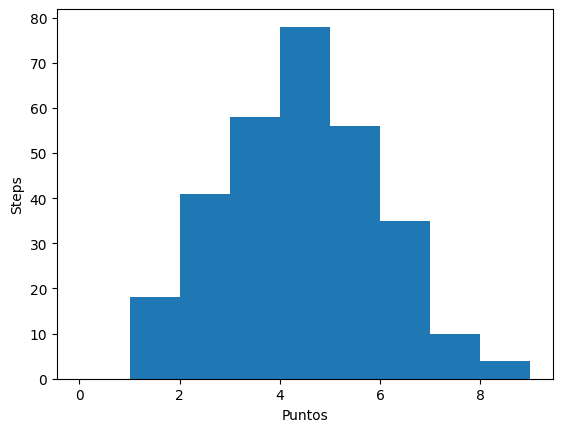

In [74]:
puntaje = []

# This runs the model 100 times, each model executing 10 steps.
for j in range(100):
    # Run the model
    model = CleanModel(3, 10, 10, 10)
    for i in range(100):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        puntaje.append(agent.numClean)

plt.hist(puntaje, bins=range(max(puntaje) + 1))
plt.xlabel("Puntos")
plt.ylabel("Steps")

In [75]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.tail()

Wealth
Step AgentID        
98   1             6
     2             3
99   0             4
     1             6
     2             3

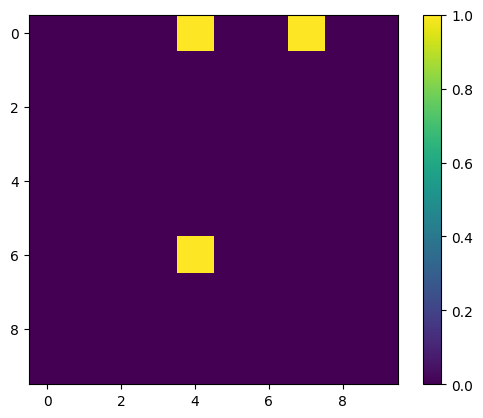

In [76]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation="nearest")
plt.colorbar()

Text(0, 0.5, 'Gini value')

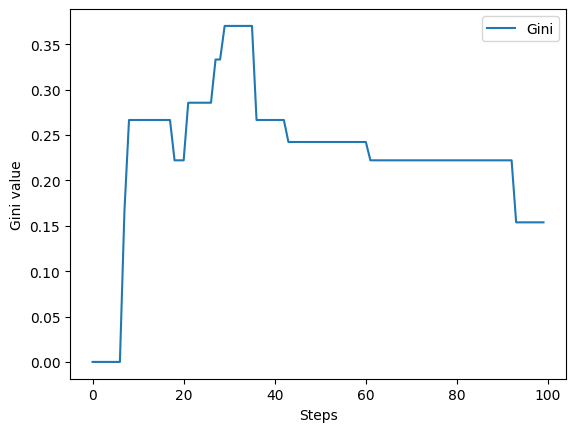

In [77]:
gini = model.datacollector.get_model_vars_dataframe()
giniPlot= gini.plot()
giniPlot.set_xlabel("Steps")
giniPlot.set_ylabel("Gini value")

In [78]:
params = {"width": 10,  "height": 10, "N": 5,"Trash": 20}
results = mesa.batch_run(
    CleanModel,
    parameters=params,
    iterations=5,
    max_steps=50,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

100%|██████████| 5/5 [00:00<00:00, 894.35it/s]


In [79]:
import pandas as pd

results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'N', 'Trash', 'Gini',
       'AgentID', 'Wealth'],
      dtype='object')


Text(0, 0.5, 'iteraciones')

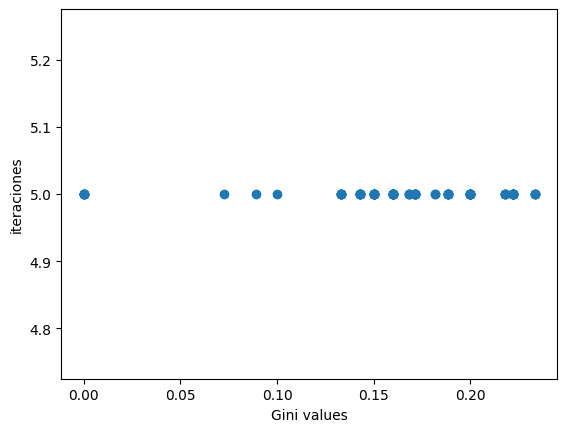

In [80]:
results_filtered = results_df[(results_df.AgentID == 1) & (results_df.Step <= 100)]

N_values = results_filtered.N.values
gini_values = results_filtered.Gini.values
plt.scatter(gini_values,N_values)
plt.xlabel("Gini values")
plt.ylabel("iteraciones")

In [81]:
one_episode_wealth = results_df
print(
    one_episode_wealth.to_string(
        index=False, columns=["Step", "AgentID", "Wealth"], max_rows=25
    )
)

 Step  AgentID  Wealth
    0        0       1
    0        1       1
    0        2       1
    0        3       1
    0        4       1
    1        0       1
    1        1       1
    1        2       1
    1        3       2
    1        4       1
    2        0       2
    2        1       1
  ...      ...     ...
   48        3       4
   48        4       2
   49        0       5
   49        1       5
   49        2       3
   49        3       4
   49        4       2
   50        0       5
   50        1       5
   50        2       3
   50        3       4
   50        4       2


In [82]:
results_one_episode = results_df

print(results_one_episode.to_string(index=False, columns=["Step", "Gini"], max_rows=25))

 Step     Gini
    0 0.000000
    0 0.000000
    0 0.000000
    0 0.000000
    0 0.000000
    1 0.133333
    1 0.133333
    1 0.133333
    1 0.133333
    1 0.133333
    2 0.171429
    2 0.171429
  ...      ...
   48 0.168421
   48 0.168421
   49 0.168421
   49 0.168421
   49 0.168421
   49 0.168421
   49 0.168421
   50 0.168421
   50 0.168421
   50 0.168421
   50 0.168421
   50 0.168421


Text(0, 0.5, 'Puntaje')

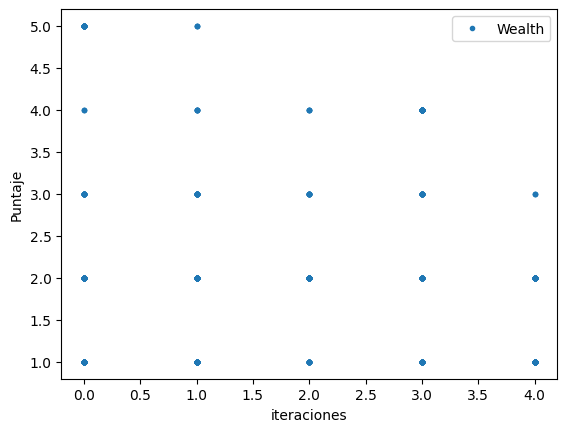

In [83]:
graf = results_df.plot(x='AgentID', y='Wealth', style='.')
graf.set_xlabel("iteraciones")
graf.set_ylabel("Puntaje")

Text(0, 0.5, 'Puntaje')

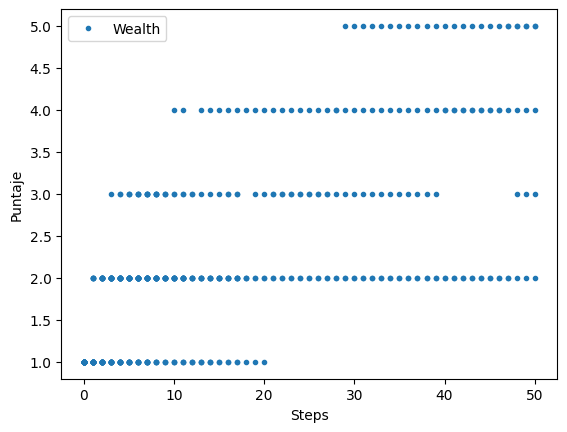

In [84]:
graf2 = results_df.plot(x='Step', y='Wealth',style='.')
graf2.set_xlabel("Steps")
graf2.set_ylabel("Puntaje")
